In [27]:
import pandas as pd
sample = pd.read_csv('/opt/ml/input/data/poc/KakaoTalk_Chat_IT개발자 구직_채용 정보교류방 (비번 2186)_2023-01-11-12-07-28.csv',engine='python', encoding = "utf8")
sample['Message2'] = pd.concat([pd.Series('None'),sample['Message'][:-1]]).reset_index(drop=True)

In [28]:
sample['Date'] = pd.to_datetime(sample['Date'],infer_datetime_format=True)

In [29]:
# 일자별로 시간을 자르는 기준
df_filtered2 = sample[ sample['Date'].isin(pd.date_range('2022-12-16', '2022-12-17',freq = 's'))]

In [30]:
context = list(df_filtered2['Message'])
print(context)

['roy님이 들어왔습니다.\n운영정책을 위반한 메시지로 신고 접수 시 카카오톡 이용에 제한이 있을 수 있습니다.', '입장 후 즉시 다음의 공지를 필독해주세요. 링크: https://bit.ly/32nBd2U', '꾸라님이 들어왔습니다.', '입장 후 즉시 다음의 공지를 필독해주세요. 링크: https://bit.ly/32nBd2U', '형님들 리액트 하다가 궁금한 거 하나만 여쭤보겟습니다 리액트에서 api 연동해야하는데 로그인같은 api는 여러컴포넌트에서 써서 redux가 필요한듯한데 두 개의 컴포넌트에서 api(이 경우에는 글 crud 하는 api) 를 써야해서 이것도 redux를 쓸지 고민이 됩니다', '그냥 컴포넌트에서 호출해버릴까 vs redux 로 할까', 'api호출 위치는 하위 컴포넌트에 있어도 상관없는데 로그인한 상태 결과 저장은 최상위나 store에 있는게 맞을듯요', '아하 감사합니다~!', '로그인정보는 redux를 쓰지않고 contextAPI로 구현하는거에 대해서 어떻게 생각하시나요', '솔직히 redux 어제 부터 공부했는데 너무 어려워서 그냥 contextAPI로 처리하고 싶은 마음이 큽니다 ㅎㅎ 근데 취업하려면 redux 알아야할 것같아서 조금 고민이 되요 ', '리액트부분중에 제일 까다로운게 리덕스 아닌가요', '프론트 하실거면 리덕스 꼭 하시고', '백엔드인데 프론트 찍먹만 할거면 컨텍스트로 충분해여', '리덕스도 앵귤러 ngrx에 비하면 양반이더군요 ㄷㄷ', '해보시는걸 추천해요', '상태관리 라이브러리 ㅈㄴ 많아서 내가 리덕스를 배워도 회사에서는 안쓸 수 있거든요', '그래도 전역 상태관리 작동방식의 보편적인건 redux랑 redux-toolkit이고', '추가로 recoil정도 알아두시면', '앵간해서는 괜찮아요', '혹시 다른 인턴 결과 나오기전에 하나가 붙어버리면 일단 거기로 간다고 답변드려야 할려나요?', '다른회사 결과 기다리고있다고 시간달라고 하믄대죠 ', '다른회사는 발표가 얼마나 남으셨나요', '그거를 모르겠

In [31]:
import re
import numpy
import math
from nltk.tokenize import TextTilingTokenizer

In [32]:
BLOCK_COMPARISON, VOCABULARY_INTRODUCTION = 0, 1
LC, HC = 0, 1
DEFAULT_SMOOTHING = [0]

In [33]:
class KorTextTilingTokenizer(TextTilingTokenizer):

    def __init__(
        self,
        w=20,
        k=10,
        similarity_method=0,
        stopwords=None,
        smoothing_method=[0],
        smoothing_width=2,
        smoothing_rounds=1,
        cutoff_policy=1,
        demo_mode=False,
    ):
        super().__init__()

        if stopwords is None:
            stopwords = [] #🦊 stopword 사용하지 않음
        self.__dict__.update(locals())
        del self.__dict__["self"]

    def tokenize(self, text): 
        """Return a tokenized copy of *text*, where each "token" represents
        a separate topic."""

        lowercase_text = text.lower()

        # STEP 0. 인풋이 구조적으로 문단을 나누는 경우 분리점을 찾음 ("[ \t\r\f\v]*\n[ \t\r\f\v]*\n[ \t\r\f\v]*" 등)
        paragraph_breaks = self._mark_paragraph_breaks(text)
        text_length = len(lowercase_text)

        # STEP 1. 토크나이징 진행

        # 1-1) 글자를 제외한 문장부호 등을 제거함
        nopunct_text = "".join(  c for c in lowercase_text if re.match(r"[ㄱ-힣0-9a-z\-' \n\t]", c) ) #🦊

        nopunct_par_breaks = self._mark_paragraph_breaks(nopunct_text)

        # 1-2) 토큰 시퀀스로 나누기 => "문장"의 단위가 됨
        tokseqs = self._divide_to_tokensequences(nopunct_text)

        # Filter stopwords => 한국어에서는 적용되지 않음
        for ts in tokseqs:
            ts.wrdindex_list = [
                wi for wi in ts.wrdindex_list if wi[0] not in self.stopwords
            ]

        # STEP 3. 문단 / 문장 별로 단어의 등장 횟수를 체크해 표를 만들기
        token_table = self._create_token_table(tokseqs, nopunct_par_breaks)
        # End of the Tokenization step
        
        # Lexical score determination
        if self.similarity_method == 0:
            gap_scores = self._block_comparison(tokseqs, token_table)
        elif self.similarity_method == 1:
            raise NotImplementedError("Vocabulary introduction not implemented")
        else:
            raise ValueError(
                f"Similarity method {self.similarity_method} not recognized"
            )

        if self.smoothing_method == [0]:
            smooth_scores = self._smooth_scores(gap_scores)
        else:
            raise ValueError(f"Smoothing method {self.smoothing_method} not recognized")
        # End of Lexical score Determination

        # Boundary identification
        depth_scores = self._depth_scores(smooth_scores)
        segment_boundaries = self._identify_boundaries(depth_scores)

        normalized_boundaries = self._normalize_boundaries(
            text, segment_boundaries, paragraph_breaks
        )
        # End of Boundary Identification
        segmented_text = []
        prevb = 0

        for b in normalized_boundaries:
            if b == 0:
                continue
            segmented_text.append(text[prevb:b])
            prevb = b

        if prevb < text_length:  # append any text that may be remaining
            segmented_text.append(text[prevb:])

        if not segmented_text:
            segmented_text = [text]

        if self.demo_mode:
            return gap_scores, smooth_scores, depth_scores, segment_boundaries
        return segmented_text

In [34]:
## 형태소 분석 함수 정의 - konlpy의 트위터 형태소 분석기 활용

import konlpy
twitter = konlpy.tag.Twitter()

def my_tokenizer(sentence) :
  """트위터 분석기를 활용해 문장부호 제거 / 원형 복원 & 정규화 토크나이징한 결과 리턴 """
  return[res[0] for res in twitter.pos(sentence, norm=True, stem=True) if res[1] != "Punctuation"]

print(my_tokenizer("내가 만든 토크나이저 테스트하기!"))

# konlpy 활용해 형태소 분석 & 원형 복원 먼저 진행
tokenized_dialog = []
for text in context:
  tokenized_text = my_tokenizer(text)
  tokenized_dialog.append(" ".join(tokenized_text))

# 결과 프린트해보기
print("토크나이징한 스크립트 :")
for idx, utterance in enumerate(tokenized_dialog[:10]):
  print("{} > {}".format(idx, utterance))

/opt/conda/envs/MRC_bora/lib/python3.10/site-packages/konlpy/tag/_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


['내', '가', '만들다', '토크', '나이', '저', '테스트', '하다']
토크나이징한 스크립트 :
0 > roy 님 이 들어오다 
 운영 정책 을 위반 한 메시지 로 신고 접수 시 카카오 톡 이용 에 제한 이 있다 수 있다
1 > 입장 후 즉시 다음 의 공지 를 필독 해주다 링크 https://bit.ly/32nBd2U
2 > 꾸라님 이 들어오다
3 > 입장 후 즉시 다음 의 공지 를 필독 해주다 링크 https://bit.ly/32nBd2U
4 > 형님 들 리액트 하다 궁금하다 거 하나 만 여쭈다 보다 리액트 에서 api 연동 하다 로그인 같다 api 늘다 여러 컴포넌트 에서 써다 redux 가다 필요하다 한 데 두 개 의 컴포넌트 에서 api 이 경우 에는 글 crud 하다 api 를 써다 하다 이 것 도 redux 를 쓸다 고민 이 되다
5 > 그냥 컴포넌트 에서 호출 하다 버리다 vs redux 로 하다
6 > api 호출 위치 는 하위 컴포넌트 에 있다 상관없다 로그인 한 상태 결과 저장 은 최 상위 나 store 에 있다 맞다 듯 요
7 > 아하 감사하다
8 > 로그인 정보 는 redux 를 쓰다 않다 contextAPI 로 구현 하다 대해 서 어떻다 생각 하다
9 > 솔직하다 redux 어제 부터 공부 하다 너무 어렵다 그냥 contextAPI 로 처리 하고 싶다 마음 이 크다 ㅎㅎ 근데 취업 하다 redux 알 아 야하다 것 같다 조금 고민 이 되다


In [35]:
# TextTiling 인풋으로 만들기

input_text = ""
for idx, text in enumerate(tokenized_dialog) :
  input_text += text + " "
input_text += "\n\n\t"
input_text[:500]

'roy 님 이 들어오다 \n 운영 정책 을 위반 한 메시지 로 신고 접수 시 카카오 톡 이용 에 제한 이 있다 수 있다 입장 후 즉시 다음 의 공지 를 필독 해주다 링크 https://bit.ly/32nBd2U 꾸라님 이 들어오다 입장 후 즉시 다음 의 공지 를 필독 해주다 링크 https://bit.ly/32nBd2U 형님 들 리액트 하다 궁금하다 거 하나 만 여쭈다 보다 리액트 에서 api 연동 하다 로그인 같다 api 늘다 여러 컴포넌트 에서 써다 redux 가다 필요하다 한 데 두 개 의 컴포넌트 에서 api 이 경우 에는 글 crud 하다 api 를 써다 하다 이 것 도 redux 를 쓸다 고민 이 되다 그냥 컴포넌트 에서 호출 하다 버리다 vs redux 로 하다 api 호출 위치 는 하위 컴포넌트 에 있다 상관없다 로그인 한 상태 결과 저장 은 최 상위 나 store 에 있다 맞다 듯 요 아하 감사하다 로그인 정보 는 redux 를 쓰다 않다 contextAPI 로 구현 '

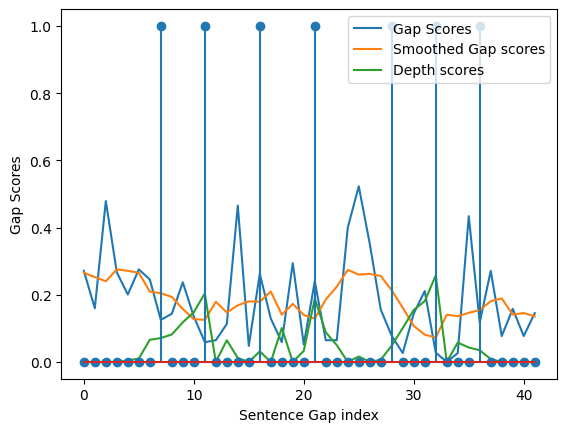

In [36]:
SENTENCE_SIZE = 30
WINDOW_SIZE = 1

tt = KorTextTilingTokenizer(w=SENTENCE_SIZE, k=WINDOW_SIZE, similarity_method=0,
        stopwords=None,
        smoothing_method=[0],
        smoothing_width=5,
        smoothing_rounds=1,
        cutoff_policy=1,
        demo_mode=True)

from matplotlib import pylab
s, ss, d, b = tt.tokenize(input_text)
pylab.xlabel("Sentence Gap index")
pylab.ylabel("Gap Scores")
pylab.plot(range(len(s)), s, label="Gap Scores")
pylab.plot(range(len(ss)), ss, label="Smoothed Gap scores")
pylab.plot(range(len(d)), d, label="Depth scores")
pylab.stem(range(len(b)), b)
pylab.legend()
pylab.show()
pylab.close()

In [37]:
text = input_text.split()
w = SENTENCE_SIZE
windowed_text_ = [ text[i : i + w] for i in range(0, len(text), w) ]
boundary_sents = []
for idx, sent in enumerate(windowed_text_):
  try:
    if b[idx] == 1 :
      boundary_sents.append(" ".join(sent))
  except:
    pass

print("** {}개 발화문을 {}개 segment로 분류 **\n".format(len(context), len(boundary_sents)))

tokenized_sent = ""
for idx, sent in enumerate(context):
  tokenized_sent += tokenized_dialog[idx] + " "
  print("{} > {}".format(idx, sent))

  for b_text in boundary_sents:
    if b_text in tokenized_sent:
      print("-" * 150)
      tokenized_sent = ""

** 212개 발화문을 7개 segment로 분류 **

0 > roy님이 들어왔습니다.
운영정책을 위반한 메시지로 신고 접수 시 카카오톡 이용에 제한이 있을 수 있습니다.
1 > 입장 후 즉시 다음의 공지를 필독해주세요. 링크: https://bit.ly/32nBd2U
2 > 꾸라님이 들어왔습니다.
3 > 입장 후 즉시 다음의 공지를 필독해주세요. 링크: https://bit.ly/32nBd2U
4 > 형님들 리액트 하다가 궁금한 거 하나만 여쭤보겟습니다 리액트에서 api 연동해야하는데 로그인같은 api는 여러컴포넌트에서 써서 redux가 필요한듯한데 두 개의 컴포넌트에서 api(이 경우에는 글 crud 하는 api) 를 써야해서 이것도 redux를 쓸지 고민이 됩니다
5 > 그냥 컴포넌트에서 호출해버릴까 vs redux 로 할까
6 > api호출 위치는 하위 컴포넌트에 있어도 상관없는데 로그인한 상태 결과 저장은 최상위나 store에 있는게 맞을듯요
7 > 아하 감사합니다~!
8 > 로그인정보는 redux를 쓰지않고 contextAPI로 구현하는거에 대해서 어떻게 생각하시나요
9 > 솔직히 redux 어제 부터 공부했는데 너무 어려워서 그냥 contextAPI로 처리하고 싶은 마음이 큽니다 ㅎㅎ 근데 취업하려면 redux 알아야할 것같아서 조금 고민이 되요 
10 > 리액트부분중에 제일 까다로운게 리덕스 아닌가요
11 > 프론트 하실거면 리덕스 꼭 하시고
12 > 백엔드인데 프론트 찍먹만 할거면 컨텍스트로 충분해여
13 > 리덕스도 앵귤러 ngrx에 비하면 양반이더군요 ㄷㄷ
14 > 해보시는걸 추천해요
15 > 상태관리 라이브러리 ㅈㄴ 많아서 내가 리덕스를 배워도 회사에서는 안쓸 수 있거든요
16 > 그래도 전역 상태관리 작동방식의 보편적인건 redux랑 redux-toolkit이고
--------------------------------------------------------------------------------------------------